<a href="https://colab.research.google.com/github/Mukti2100/UTS-Machine-Vision/blob/main/UAS_machine_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from PIL import Image
from torch import nn
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
import time
from tqdm import tqdm

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# File paths
train_data_path = '/content/drive/MyDrive/EMNIST/emnist-bymerge-train.csv'
val_data_path = '/content/drive/MyDrive/EMNIST/emnist-bymerge-test.csv'

# Load data
data_train = pd.read_csv(train_data_path, header=None, nrows=500)
data_val = pd.read_csv(val_data_path, header=None, nrows=500)
print("Dataset loaded successfully.")

Dataset loaded successfully.


In [4]:
# Preprocess image function
def preprocess_image(data):
    data = np.clip(data, 0, 255).astype(np.uint8).reshape(28, 28)
    return Image.fromarray(data).convert("RGB")

In [5]:
# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        label = self.dataframe.iloc[idx, 0]
        img_data = self.dataframe.iloc[idx, 1:].values
        image = preprocess_image(img_data)
        if self.transform:
            image = self.transform(image)
        return image, label

In [6]:
# Data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
# Initialize datasets
train_dataset = CustomDataset(data_train, transform=data_transforms)
val_dataset = CustomDataset(data_val, transform=data_transforms)

In [8]:
# Define model
model = models.alexnet(pretrained=True)
model.classifier[6] = nn.Linear(4096, 47)
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 161MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [9]:
# Freeze feature extractor
for param in model.features.parameters():
    param.requires_grad = False

In [10]:
# Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [11]:
# Leave-One-Out Cross Validation (LOOCV)
data_array = data_train.to_numpy()
loo = LeaveOneOut()

all_preds, all_labels = [], []

print("Starting LOOCV...")
start_time = time.time()

for train_idx, test_idx in tqdm(loo.split(data_array)):
    # Split data into training and testing sets for the current fold
    train_samples = data_array[train_idx]
    test_sample = data_array[test_idx]

    # Create datasets and dataloaders for this fold
    train_dataset = CustomDataset(pd.DataFrame(train_samples), transform=data_transforms)
    test_dataset = CustomDataset(pd.DataFrame(test_sample), transform=data_transforms)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Reinitialize the model for each fold
    model = models.alexnet(pretrained=True)
    model.classifier[6] = nn.Linear(4096, 47)
    model.to(device)

    # Freeze feature extractor
    for param in model.features.parameters():
        param.requires_grad = False

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    # Training loop for the current fold
    model.train()
    for epoch in range(1):  # Set epochs to 1 for LOOCV (can be increased for better performance)
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Validation loop for the current fold
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            all_preds.append(torch.argmax(outputs, dim=1).cpu().item())
            all_labels.append(labels.cpu().item())

end_time = time.time()
print(f"Total Execution Time: {end_time - start_time:.2f} seconds")

Starting LOOCV...


500it [14:36,  1.75s/it]

Total Execution Time: 876.67 seconds


In [12]:
# Calculate evaluation metrics
conf_matrix = confusion_matrix(all_labels, all_preds)
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro')

In [13]:
# Display evaluation results
print("\nEvaluation Results:")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy*100:.4f}")
print(f"Precision: {precision*100:.4f}")
print(f"F1-Score: {f1*100:.4f}")


Evaluation Results:
Confusion Matrix:
[[27  0  0 ...  0  0  0]
 [ 0 22  0 ...  0  0  0]
 [ 5  0  5 ...  0  0  1]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 1  1  0 ...  0  0  1]
 [ 0  3  1 ...  0  0  6]]
Accuracy: 30.8000
Precision: 8.6426
F1-Score: 9.5179


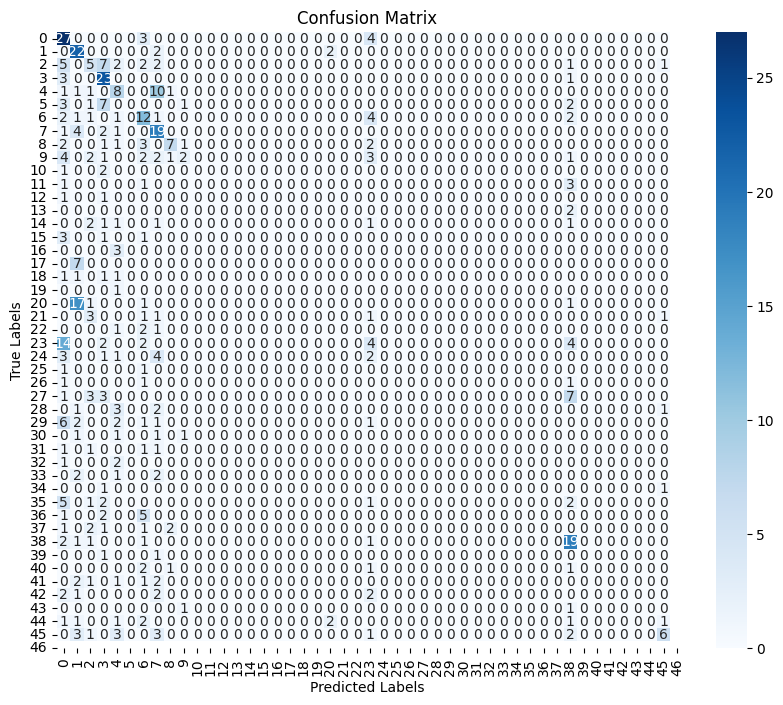

In [14]:
# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(47), yticklabels=range(47))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()